## PDF Fit

### plot 1

In [93]:
# To run once
n_replicas_PDF = 300

MuC_Energy = 10 # TeV

luminosity = 1.5e9

Z = 74
A = 184

n_replicas_D = 8
n_replicas_B = 40
n_replicas_K = 160

n_replicas_PDF_2 = 40

PID = 'g'


In [94]:


path = f"results/{MuC_Energy}_TeV_{n_replicas_PDF}_PDF_{n_replicas_D}_D_{n_replicas_B}_B_{n_replicas_K}_K_{int(luminosity/1e6)}_abe-1_Z_{Z}_A_{A}"

import lhapdf
import numpy as np
import matplotlib.pyplot as plt
import os 

pdf_set_name = f"new_PDF4LHC21_300"
pset = lhapdf.getPDFSet(pdf_set_name)
pdfs = pset.mkPDFs()
n_replicas = n_replicas_PDF 

pdf_set_name_2 = f"new_PDF4LHC21_300"
pset_2 = lhapdf.getPDFSet(pdf_set_name_2)
pdfs_2 = pset_2.mkPDFs()
n_replicas_2 = n_replicas_PDF_2

M_inv = np.load(f"{path}/covariance_matrix_full.npy")


LHAPDF 6.5.5 loading all 301 PDFs in set new_PDF4LHC21_300
new_PDF4LHC21_300, version 1; 301 PDF members
LHAPDF 6.5.5 loading all 301 PDFs in set new_PDF4LHC21_300
new_PDF4LHC21_300, version 1; 301 PDF members


In [95]:
["u", "ub", "d", "db", "s", "sb", "c", "cb", "g",]

['u', 'ub', 'd', 'db', 's', 'sb', 'c', 'cb', 'g']

In [96]:
M_inv_PDF = M_inv[6+1:n_replicas_PDF+6+1, 6+1:n_replicas_PDF+6+1]
#M_inv_PDF = M_inv
print(M_inv_PDF.shape)
print(f"Calculating PDF uncertainty for {PID}...")
M_PDF = np.linalg.inv(M_inv_PDF)

σ, O = np.linalg.eigh(M_PDF)
σ = 1/np.sqrt(σ)

PID_dict = {
        "u" :1,
        "ub": -1,
        "d": 2,
        "db": -2,
        "s": 3,
        "sb": -3,
        "c": 4,
        "cb": -4,
        "g": 21,
}

def PDF_replica(λ, x, Q2, σ, O, PID):
    return  pdfs[0].xfxQ2(PID, x, Q2) + σ[λ] * sum(
                    O[k, λ] * (pdfs[k+1].xfxQ2(PID, x, Q2) - pdfs[0].xfxQ2(PID, x, Q2))
                    for k in range(0,len(pdfs)-1)
        )
    
pdfs = pdfs[0:n_replicas+1]
print(f"len pdfs: {len(pdfs)}")

# Strange
x = np.logspace(-4,0,100)
Q2 = 3.15e2
err_pdf_old = []
err_pdf_new = []




if PID not in PID_dict and PID != "u+d" and PID != "ub+db" and PID != "u-d":
    raise ValueError(f"Invalid PDF option: {PID}. Choose from {list(PID_dict.keys())}")

elif PID == "u+d":
    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) + pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(1,xi,Q2)-pdfs[0].xfxQ2(1,xi,Q2) + pdfs[λ].xfxQ2(2,xi,Q2)-pdfs[0].xfxQ2(2,xi,Q2) )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p/2)))


    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) + pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, 1) + PDF_replica(λ, xi, Q2, σ, O, 2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p/2)))

        
        

elif PID == "ub+db":
    for xi in x:
        p_central = pdfs[0].xfxQ2(-1, xi, Q2) + pdfs[0].xfxQ2(-2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(-1,xi,Q2)-pdfs[0].xfxQ2(-1,xi,Q2) + pdfs[λ].xfxQ2(-2,xi,Q2)-pdfs[0].xfxQ2(-2,xi,Q2) )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p/2)))

    for xi in x:
        p_central = pdfs[0].xfxQ2(-1, xi, Q2) + pdfs[0].xfxQ2(-2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, -1) + PDF_replica(λ, xi, Q2, σ, O, -2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p/2)))


elif PID == "u-d":
    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) - pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(1,xi,Q2)-  pdfs[λ].xfxQ2(2,xi,Q2) - p_central )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/abs(p/2)))

    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) - pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, 1) - PDF_replica(λ, xi, Q2, σ, O, 2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/abs(p/2)))


else :
    PID_pdf = PID_dict[PID]
    for xi in x:
        p_central = pdfs[0].xfxQ2(PID_pdf, xi, Q2) 
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(PID_pdf,xi,Q2)-p_central  )**2  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p)))
    print("done old")
    for xi in x:
        p_central = pdfs[0].xfxQ2(PID_pdf, xi, Q2) 
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, PID_pdf) - p )**2  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p)))
        


err_pdf_old_1 = np.array(err_pdf_old)
err_pdf_new_1 = np.array(err_pdf_new)


# print("done new")
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=18)


# plt.plot(*zip(*err_pdf_old), label = 'Prior', color = 'gray', linewidth=2)
# plt.fill_between(*zip(*err_pdf_old), alpha=0.2, color = 'gray')
# plt.plot(*zip(*err_pdf_new), label = 'Posterior', linewidth=2)
# plt.fill_between(*zip(*err_pdf_new), alpha=0.2)
# # Controlla il segno in PID_dict
# quark = PID 
# if PID_dict[PID] < 0:
#     # Trova la chiave con valore positivo corrispondente
#     key = next(k for k, v in PID_dict.items() if v == -PID_dict[PID])
#     # Rimuovo eventuale 'b' finale
#     if key.endswith('b'):
#         key = key[:-1]
#     label = r"\bar{{{}}}".format(key)
# else:
#     label = quark  # normale

# # Titolo con LaTeX
# title = r"$x{}(x, Q^2 = {:g} \,\mathrm{{GeV}}^2)$".format(label, Q2)
# plt.title(title, fontsize = 18, pad=15)


# plt.xlabel('$x$', fontsize=18)
# plt.ylabel('Relative Uncertainty Size', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-4,0.5)
# plt.ylim(1e-4,1e1)
# plt.legend(loc = 'upper left', fontsize=18)
# # plt.grid()
# plt.tick_params(axis='both', direction='in', which='major', length=6, width=1.5)
# plt.tick_params(axis='both', direction='in', which='minor', length=3, width=1)
# plt.tick_params(axis='both', which='major', labelsize=18)
# plt.tick_params(axis='both', which='minor', labelsize=18)

# if not os.path.exists(f"{path}/PDF"):
#         os.makedirs(f"{path}/PDF", exist_ok=True)

# plt.savefig(f"{path}/PDF/{PID}_{n_replicas_PDF}.png")
# plt.savefig(f"{path}/PDF/{PID}_{n_replicas_PDF}.pdf")
# plt.show()
# plt.clf()


(300, 300)
Calculating PDF uncertainty for g...
len pdfs: 301
done old


### plot 2

In [97]:
# To run once
n_replicas_PDF = 40

MuC_Energy = 10 # TeV

luminosity = 1.5e9

Z = 74
A = 184

n_replicas_D = 8
n_replicas_B = 40
n_replicas_K = 160



In [98]:


path = f"results/{MuC_Energy}_TeV_{n_replicas_PDF}_PDF_{n_replicas_D}_D_{n_replicas_B}_B_{n_replicas_K}_K_{int(luminosity/1e6)}_abe-1_Z_{Z}_A_{A}"

import lhapdf
import numpy as np
import matplotlib.pyplot as plt
import os 

pdf_set_name = f"new_PDF4LHC21_300"
pset = lhapdf.getPDFSet(pdf_set_name)
pdfs = pset.mkPDFs()
n_replicas = n_replicas_PDF 

pdf_set_name_2 = f"new_PDF4LHC21_300"
pset_2 = lhapdf.getPDFSet(pdf_set_name_2)
pdfs_2 = pset_2.mkPDFs()
n_replicas_2 = n_replicas_PDF_2

M_inv = np.load(f"{path}/covariance_matrix_full.npy")


LHAPDF 6.5.5 loading all 301 PDFs in set new_PDF4LHC21_300
new_PDF4LHC21_300, version 1; 301 PDF members
LHAPDF 6.5.5 loading all 301 PDFs in set new_PDF4LHC21_300
new_PDF4LHC21_300, version 1; 301 PDF members


In [99]:
M_inv_PDF = M_inv[6+1:n_replicas_PDF+6+1, 6+1:n_replicas_PDF+6+1]
#M_inv_PDF = M_inv
print(M_inv_PDF.shape)
print(f"Calculating PDF uncertainty for {PID}...")
M_PDF = np.linalg.inv(M_inv_PDF)

σ, O = np.linalg.eigh(M_PDF)
σ = 1/np.sqrt(σ)

PID_dict = {
        "u" :1,
        "ub": -1,
        "d": 2,
        "db": -2,
        "s": 3,
        "sb": -3,
        "c": 4,
        "cb": -4,
        "g": 21,
}

def PDF_replica(λ, x, Q2, σ, O, PID):
    return  pdfs[0].xfxQ2(PID, x, Q2) + σ[λ] * sum(
                    O[k, λ] * (pdfs[k+1].xfxQ2(PID, x, Q2) - pdfs[0].xfxQ2(PID, x, Q2))
                    for k in range(0,len(pdfs)-1)
        )
    
pdfs = pdfs[0:n_replicas+1]
print(f"len pdfs: {len(pdfs)}")

# Strange
x = np.logspace(-4,0,100)
Q2 = 3.15e2
err_pdf_old = []
err_pdf_new = []




if PID not in PID_dict and PID != "u+d" and PID != "ub+db" and PID != "u-d":
    raise ValueError(f"Invalid PDF option: {PID}. Choose from {list(PID_dict.keys())}")

elif PID == "u+d":
    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) + pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(1,xi,Q2)-pdfs[0].xfxQ2(1,xi,Q2) + pdfs[λ].xfxQ2(2,xi,Q2)-pdfs[0].xfxQ2(2,xi,Q2) )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p/2)))


    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) + pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, 1) + PDF_replica(λ, xi, Q2, σ, O, 2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p/2)))

        
        

elif PID == "ub+db":
    for xi in x:
        p_central = pdfs[0].xfxQ2(-1, xi, Q2) + pdfs[0].xfxQ2(-2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(-1,xi,Q2)-pdfs[0].xfxQ2(-1,xi,Q2) + pdfs[λ].xfxQ2(-2,xi,Q2)-pdfs[0].xfxQ2(-2,xi,Q2) )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p/2)))

    for xi in x:
        p_central = pdfs[0].xfxQ2(-1, xi, Q2) + pdfs[0].xfxQ2(-2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, -1) + PDF_replica(λ, xi, Q2, σ, O, -2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p/2)))


elif PID == "u-d":
    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) - pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(1,xi,Q2)-  pdfs[λ].xfxQ2(2,xi,Q2) - p_central )**2/4  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/abs(p/2)))

    for xi in x:
        p_central = pdfs[0].xfxQ2(1, xi, Q2) - pdfs[0].xfxQ2(2, xi, Q2)
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, 1) - PDF_replica(λ, xi, Q2, σ, O, 2) - p )**2/4  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/abs(p/2)))


else :
    PID_pdf = PID_dict[PID]
    for xi in x:
        p_central = pdfs[0].xfxQ2(PID_pdf, xi, Q2) 
        p = p_central
        delta_replica = np.array([(pdfs[λ].xfxQ2(PID_pdf,xi,Q2)-p_central  )**2  for λ in range(1,n_replicas+1)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_old.append((xi, err/(p)))
    print("done old")
    for xi in x:
        p_central = pdfs[0].xfxQ2(PID_pdf, xi, Q2) 
        p = p_central
        delta_replica = np.array([(PDF_replica(λ, xi, Q2, σ, O, PID_pdf) - p )**2  for λ in range(0,n_replicas)] )
        err = np.sqrt(np.sum(delta_replica)) 
        err_pdf_new.append((xi, err/(p)))
        

err_pdf_old_2 = np.array(err_pdf_old)
err_pdf_new_2 = np.array(err_pdf_new)


# print("done new")
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=18)


# # plt.plot(*zip(*err_pdf_old), label = 'Prior', color = 'gray', linewidth=2)
# # plt.fill_between(*zip(*err_pdf_old), alpha=0.2, color = 'gray')
# plt.plot(*zip(*err_pdf_new), label = 'Posterior', linewidth=2)
# plt.fill_between(*zip(*err_pdf_new), alpha=0.2)
# # Controlla il segno in PID_dict
# quark = PID 
# if PID_dict[PID] < 0:
#     # Trova la chiave con valore positivo corrispondente
#     key = next(k for k, v in PID_dict.items() if v == -PID_dict[PID])
#     # Rimuovo eventuale 'b' finale
#     if key.endswith('b'):
#         key = key[:-1]
#     label = r"\bar{{{}}}".format(key)
# else:
#     label = quark  # normale

# # Titolo con LaTeX
# title = r"$x{}(x, Q^2 = {:g} \,\mathrm{{GeV}}^2)$".format(label, Q2)
# plt.title(title, fontsize = 18, pad=15)


# plt.xlabel('$x$', fontsize=18)
# plt.ylabel('Relative Uncertainty Size', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1e-4,0.5)
# plt.ylim(1e-4,1e1)
# plt.legend(loc = 'upper left', fontsize=18)
# # plt.grid()
# plt.tick_params(axis='both', direction='in', which='major', length=6, width=1.5)
# plt.tick_params(axis='both', direction='in', which='minor', length=3, width=1)
# plt.tick_params(axis='both', which='major', labelsize=18)
# plt.tick_params(axis='both', which='minor', labelsize=18)

# if not os.path.exists(f"{path}/PDF"):
#         os.makedirs(f"{path}/PDF", exist_ok=True)

# plt.savefig(f"{path}/PDF/{PID}_{n_replicas_PDF}.png")
# plt.savefig(f"{path}/PDF/{PID}_{n_replicas_PDF}.pdf")
# plt.show()
# plt.clf()


(40, 40)
Calculating PDF uncertainty for g...
len pdfs: 41
done old


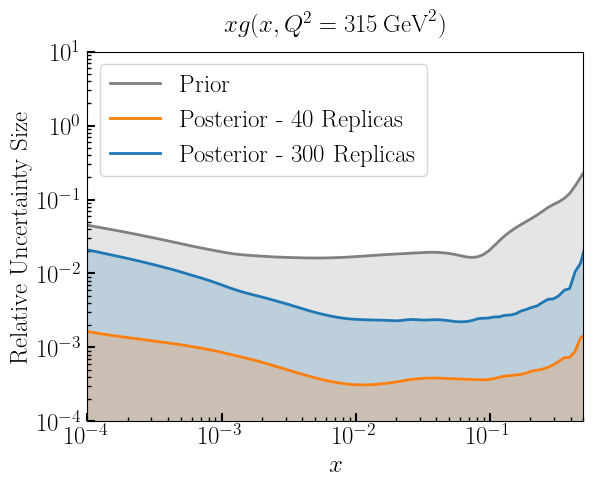

<Figure size 640x480 with 0 Axes>

In [100]:
n_replicas_1 = 300
n_replicas_2 = 40
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)


plt.plot(*zip(*err_pdf_old_1), label = 'Prior', color = 'gray', linewidth=2)
plt.fill_between(*zip(*err_pdf_old_1), alpha=0.2, color = 'gray')
plt.plot(*zip(*err_pdf_new_1), label = f'Posterior - {n_replicas_1} Replicas', linewidth=2)
plt.fill_between(*zip(*err_pdf_new_1), alpha=0.2)
plt.plot(*zip(*err_pdf_new_2), label = f'Posterior - {n_replicas_2} Replicas', linewidth=2)
plt.fill_between(*zip(*err_pdf_new_2), alpha=0.2)
# Controlla il segno in PID_dict
quark = PID 
if PID_dict[PID] < 0:
    # Trova la chiave con valore positivo corrispondente
    key = next(k for k, v in PID_dict.items() if v == -PID_dict[PID])
    # Rimuovo eventuale 'b' finale
    if key.endswith('b'):
        key = key[:-1]
    label = r"\bar{{{}}}".format(key)
else:
    label = quark  # normale

# Titolo con LaTeX
title = r"$x{}(x, Q^2 = {:g} \,\mathrm{{GeV}}^2)$".format(label, Q2)
plt.title(title, fontsize = 18, pad=15)


plt.xlabel('$x$', fontsize=18)
plt.ylabel('Relative Uncertainty Size', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,0.5)
plt.ylim(1e-4,1e1)
plt.legend(loc = 'upper left', fontsize=18)
# plt.grid()
plt.tick_params(axis='both', direction='in', which='major', length=6, width=1.5)
plt.tick_params(axis='both', direction='in', which='minor', length=3, width=1)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

if not os.path.exists(f"{path}/PDF"):
        os.makedirs(f"{path}/PDF", exist_ok=True)

# swap legend entries 2 and 3
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
if len(handles) >= 3:
    handles[1], handles[2] = handles[2], handles[1]
    labels[1], labels[2] = labels[2], labels[1]
ax.legend(handles, labels, loc='upper left', fontsize=18)

plt.savefig(f"plots/PDF/{PID}.png")
plt.savefig(f"plots/PDF/pdf_fit_{PID}_{MuC_Energy}TeV_replica_300.pdf")
plt.show()
plt.clf()
